<a href="https://colab.research.google.com/github/ameya1252/5173_HW4/blob/main/5173_HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files



data_path = 'fra.txt'


In [ ]:
# Upload the file
data_path = 'fra.txt'
uploaded_files = files.upload()

for file_name, file_content in uploaded_files.items():
    print(f'User uploaded file "{file_name}" with length {len(file_content)} bytes')

In [2]:
# Define parameters
batch_size = 64
epochs = 40
latent_dimension = 256
sample_limit = 40000
learning_rates = [0.1, 0.01, 0.001]

# Initialize data structures
eng_texts = []
fra_texts = []
eng_chars = set()
fra_chars = set()

In [3]:
# Read the data
with open(data_path, 'r', encoding='utf-8') as file:
    file_lines = file.read().split('\n')

for line in file_lines[:min(sample_limit, len(file_lines) - 1)]:
    eng_text, fra_text, _ = line.split('\t')
    fra_text = '\t' + fra_text + '\n'
    eng_texts.append(eng_text)
    fra_texts.append(fra_text)
    eng_chars.update(set(eng_text))
    fra_chars.update(set(fra_text))

eng_chars = sorted(list(eng_chars))
fra_chars = sorted(list(fra_chars))
num_eng_chars = len(eng_chars)
num_fra_chars = len(fra_chars)
max_eng_length = max([len(text) for text in eng_texts])
max_fra_length = max([len(text) for text in fra_texts])

eng_char_indices = {char: i for i, char in enumerate(eng_chars)}
fra_char_indices = {char: i for i, char in enumerate(fra_chars)}

encoder_input = np.zeros((len(eng_texts), max_eng_length, num_eng_chars), dtype='float32')
decoder_input = np.zeros((len(eng_texts), max_fra_length, num_fra_chars), dtype='float32')
decoder_target = np.zeros((len(eng_texts), max_fra_length, num_fra_chars), dtype='float32')

for i, (eng, fra) in enumerate(zip(eng_texts, fra_texts)):
    for t, char in enumerate(eng):
        encoder_input[i, t, eng_char_indices[char]] = 1.
    encoder_input[i, t + 1:, eng_char_indices[' ']] = 1.

    for t, char in enumerate(fra):
        decoder_input[i, t, fra_char_indices[char]] = 1.
        if t > 0:
            decoder_target[i, t - 1, fra_char_indices[char]] = 1.
    decoder_input[i, t + 1:, fra_char_indices[' ']] = 1.
    decoder_target[i, t:, fra_char_indices[' ']] = 1.

In [4]:


# Function to build the model
def build_model(num_layers, learning_rate):
    # Encoder
    encoder_input_layer = Input(shape=(None, num_eng_chars))
    lstm_layer = LSTM(latent_dimension, return_state=True, return_sequences=(num_layers > 1))
    encoder_output, state_h, state_c = lstm_layer(encoder_input_layer)
    encoder_states = [state_h, state_c]

    # Additional layers
    for _ in range(1, num_layers):
        lstm_layer = LSTM(latent_dimension, return_state=True, return_sequences=True)
        encoder_output, state_h, state_c = lstm_layer(encoder_output)
        encoder_states = [state_h, state_c]

    # Decoder
    decoder_input_layer = Input(shape=(None, num_fra_chars))
    decoder_lstm = LSTM(latent_dimension, return_sequences=True, return_state=True)
    decoder_output, _, _ = decoder_lstm(decoder_input_layer, initial_state=encoder_states)
    decoder_dense = Dense(num_fra_chars, activation='softmax')
    decoder_output = decoder_dense(decoder_output)

    # Model
    model = Model([encoder_input_layer, decoder_input_layer], decoder_output)
    # Compile the model with specified learning rate
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model








Epoch 1/40
500/500 [==============================] - 19s 24ms/step - loss: 5.0713 - accuracy: 0.6072 - val_loss: 4.3430 - val_accuracy: 0.6114
Epoch 2/40
500/500 [==============================] - 11s 21ms/step - loss: 4.0709 - accuracy: 0.6224 - val_loss: 4.6583 - val_accuracy: 0.6087
Epoch 3/40
500/500 [==============================] - 8s 15ms/step - loss: 4.2523 - accuracy: 0.6151 - val_loss: 4.2017 - val_accuracy: 0.6192
Epoch 4/40
500/500 [==============================] - 6s 13ms/step - loss: 4.2379 - accuracy: 0.6183 - val_loss: 3.9600 - val_accuracy: 0.5934
Epoch 5/40
500/500 [==============================] - 8s 16ms/step - loss: 4.2209 - accuracy: 0.6195 - val_loss: 3.9588 - val_accuracy: 0.6107
Epoch 6/40
500/500 [==============================] - 10s 21ms/step - loss: 4.2395 - accuracy: 0.6207 - val_loss: 4.6334 - val_accuracy: 0.6120
Epoch 7/40
500/500 [==============================] - 7s 15ms/step - loss: 4.3448 - accuracy: 0.6199 - val_loss: 5.3737 - val_accuracy: 0.6

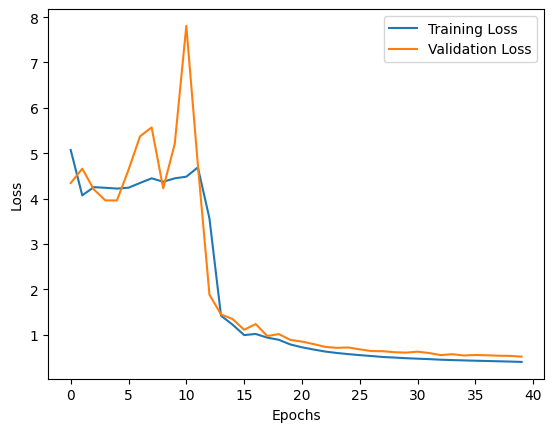

<Figure size 640x480 with 0 Axes>

In [ ]:
# Training and plotting
num_layers = 1
lr = 0.1
model = build_model(num_layers, lr)
history = model.fit([encoder_input, decoder_input], decoder_target,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2)



# Plot the training history
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.tight_layout()
plt.show()

Epoch 1/40
500/500 [==============================] - 11s 16ms/step - loss: 0.8692 - accuracy: 0.7637 - val_loss: 0.7513 - val_accuracy: 0.7768
Epoch 2/40
500/500 [==============================] - 6s 13ms/step - loss: 0.5669 - accuracy: 0.8309 - val_loss: 0.6397 - val_accuracy: 0.8075
Epoch 3/40
500/500 [==============================] - 7s 14ms/step - loss: 0.4877 - accuracy: 0.8526 - val_loss: 0.5770 - val_accuracy: 0.8262
Epoch 4/40
500/500 [==============================] - 7s 13ms/step - loss: 0.4727 - accuracy: 0.8589 - val_loss: 0.5573 - val_accuracy: 0.8293
Epoch 5/40
500/500 [==============================] - 7s 13ms/step - loss: 0.4144 - accuracy: 0.8731 - val_loss: 0.5148 - val_accuracy: 0.8428
Epoch 6/40
500/500 [==============================] - 6s 12ms/step - loss: 0.3850 - accuracy: 0.8817 - val_loss: 0.5081 - val_accuracy: 0.8449
Epoch 7/40
500/500 [==============================] - 6s 13ms/step - loss: 0.3618 - accuracy: 0.8888 - val_loss: 0.4716 - val_accuracy: 0.857

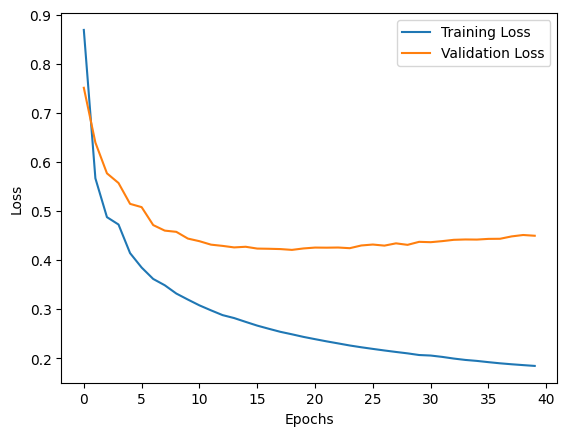

<Figure size 640x480 with 0 Axes>

In [ ]:
# Training and plotting
num_layers = 1
lr = 0.01
model = build_model(num_layers, lr)
history = model.fit([encoder_input, decoder_input], decoder_target,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2)



# Plot the training history
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.tight_layout()
plt.show()

Epoch 1/40
500/500 [==============================] - 11s 18ms/step - loss: 1.1062 - accuracy: 0.7135 - val_loss: 1.0285 - val_accuracy: 0.7023
Epoch 2/40
500/500 [==============================] - 6s 12ms/step - loss: 0.7547 - accuracy: 0.7812 - val_loss: 0.8404 - val_accuracy: 0.7531
Epoch 3/40
500/500 [==============================] - 7s 13ms/step - loss: 0.6577 - accuracy: 0.8066 - val_loss: 0.7578 - val_accuracy: 0.7760
Epoch 4/40
500/500 [==============================] - 7s 13ms/step - loss: 0.6081 - accuracy: 0.8218 - val_loss: 0.7132 - val_accuracy: 0.7890
Epoch 5/40
500/500 [==============================] - 7s 14ms/step - loss: 0.5584 - accuracy: 0.8346 - val_loss: 0.6700 - val_accuracy: 0.8019
Epoch 6/40
500/500 [==============================] - 6s 12ms/step - loss: 0.5261 - accuracy: 0.8440 - val_loss: 0.6349 - val_accuracy: 0.8113
Epoch 7/40
500/500 [==============================] - 6s 13ms/step - loss: 0.4996 - accuracy: 0.8511 - val_loss: 0.6131 - val_accuracy: 0.818

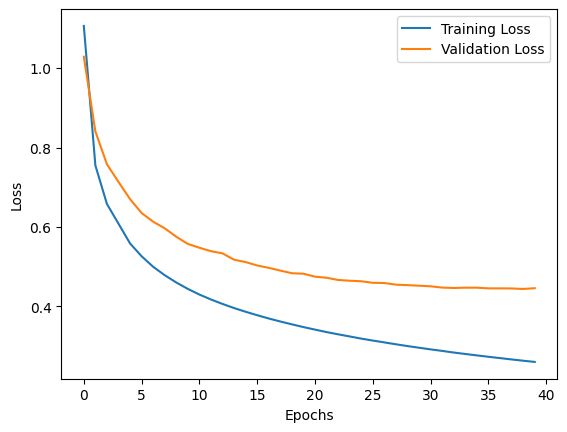

<Figure size 640x480 with 0 Axes>

In [ ]:
# Training and plotting
num_layers = 1
lr = 0.001
model = build_model(num_layers, lr)
history = model.fit([encoder_input, decoder_input], decoder_target,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2)



# Plot the training history
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.tight_layout()
plt.show()

Epoch 1/40
500/500 [==============================] - 18s 20ms/step - loss: 1.9089 - accuracy: 0.6853 - val_loss: 1.0288 - val_accuracy: 0.7168
Epoch 2/40
500/500 [==============================] - 8s 16ms/step - loss: 0.6508 - accuracy: 0.8108 - val_loss: 0.6492 - val_accuracy: 0.8082
Epoch 3/40
500/500 [==============================] - 7s 14ms/step - loss: 0.4882 - accuracy: 0.8537 - val_loss: 0.5734 - val_accuracy: 0.8268
Epoch 4/40
500/500 [==============================] - 8s 15ms/step - loss: 0.4395 - accuracy: 0.8668 - val_loss: 0.5310 - val_accuracy: 0.8363
Epoch 5/40
500/500 [==============================] - 7s 14ms/step - loss: 0.4121 - accuracy: 0.8739 - val_loss: 0.5203 - val_accuracy: 0.8449
Epoch 6/40
500/500 [==============================] - 8s 15ms/step - loss: 0.3949 - accuracy: 0.8785 - val_loss: 0.5074 - val_accuracy: 0.8449
Epoch 7/40
500/500 [==============================] - 7s 15ms/step - loss: 0.3822 - accuracy: 0.8820 - val_loss: 0.4991 - val_accuracy: 0.849

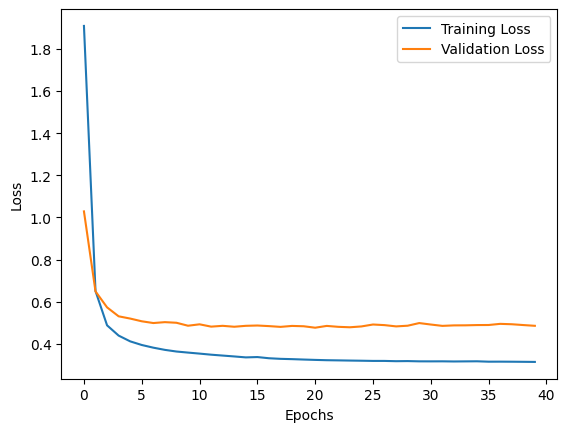

<Figure size 640x480 with 0 Axes>

In [ ]:
# Training and plotting
num_layers = 2
lr = 0.1
model = build_model(num_layers, lr)
history = model.fit([encoder_input, decoder_input], decoder_target,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2)



# Plot the training history
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.tight_layout()
plt.show()

Epoch 1/40
500/500 [==============================] - 14s 20ms/step - loss: 0.8790 - accuracy: 0.7613 - val_loss: 0.7665 - val_accuracy: 0.7703
Epoch 2/40
500/500 [==============================] - 8s 15ms/step - loss: 0.5713 - accuracy: 0.8300 - val_loss: 0.6366 - val_accuracy: 0.8088
Epoch 3/40
500/500 [==============================] - 8s 15ms/step - loss: 0.4822 - accuracy: 0.8544 - val_loss: 0.5744 - val_accuracy: 0.8270
Epoch 4/40
500/500 [==============================] - 8s 15ms/step - loss: 0.4341 - accuracy: 0.8685 - val_loss: 0.5310 - val_accuracy: 0.8405
Epoch 5/40
500/500 [==============================] - 8s 16ms/step - loss: 0.4015 - accuracy: 0.8776 - val_loss: 0.5057 - val_accuracy: 0.8473
Epoch 6/40
500/500 [==============================] - 8s 16ms/step - loss: 0.3767 - accuracy: 0.8847 - val_loss: 0.4855 - val_accuracy: 0.8528
Epoch 7/40
500/500 [==============================] - 8s 16ms/step - loss: 0.3578 - accuracy: 0.8899 - val_loss: 0.4767 - val_accuracy: 0.855

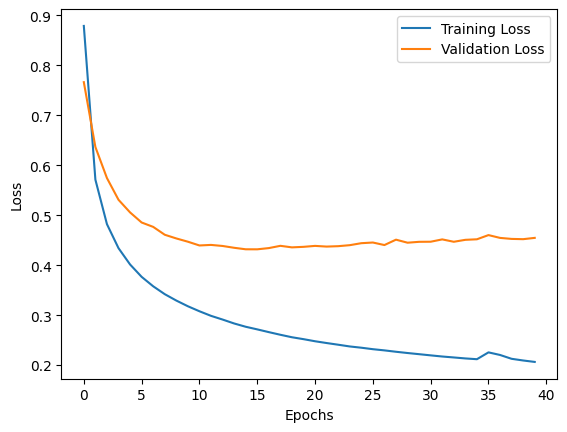

<Figure size 640x480 with 0 Axes>

In [ ]:
# Training and plotting
num_layers = 2
lr = 0.01
model = build_model(num_layers, lr)
history = model.fit([encoder_input, decoder_input], decoder_target,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2)



# Plot the training history
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.tight_layout()
plt.show()

Epoch 1/40
500/500 [==============================] - 19s 20ms/step - loss: 1.0947 - accuracy: 0.7154 - val_loss: 1.0242 - val_accuracy: 0.7009
Epoch 2/40
500/500 [==============================] - 7s 14ms/step - loss: 0.7545 - accuracy: 0.7807 - val_loss: 0.8416 - val_accuracy: 0.7541
Epoch 3/40
500/500 [==============================] - 8s 16ms/step - loss: 0.6546 - accuracy: 0.8073 - val_loss: 0.7540 - val_accuracy: 0.7761
Epoch 4/40
500/500 [==============================] - 7s 15ms/step - loss: 0.5915 - accuracy: 0.8247 - val_loss: 0.7078 - val_accuracy: 0.7892
Epoch 5/40
500/500 [==============================] - 11s 23ms/step - loss: 0.5500 - accuracy: 0.8368 - val_loss: 0.6617 - val_accuracy: 0.8033
Epoch 6/40
500/500 [==============================] - 12s 24ms/step - loss: 0.5161 - accuracy: 0.8462 - val_loss: 0.6327 - val_accuracy: 0.8115
Epoch 7/40
500/500 [==============================] - 9s 17ms/step - loss: 0.4906 - accuracy: 0.8534 - val_loss: 0.6038 - val_accuracy: 0.8

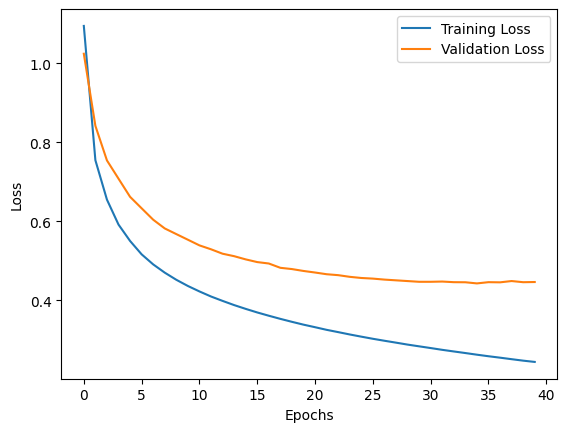

<Figure size 640x480 with 0 Axes>

In [5]:
# Training and plotting
num_layers = 2
lr = 0.001
model = build_model(num_layers, lr)
history = model.fit([encoder_input, decoder_input], decoder_target,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2)



# Plot the training history
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.tight_layout()
plt.show()

Epoch 1/40
500/500 [==============================] - 16s 23ms/step - loss: 4.4421 - accuracy: 0.6024 - val_loss: 1.8151 - val_accuracy: 0.6662
Epoch 2/40
500/500 [==============================] - 9s 18ms/step - loss: 1.0092 - accuracy: 0.7511 - val_loss: 0.9241 - val_accuracy: 0.7342
Epoch 3/40
500/500 [==============================] - 9s 18ms/step - loss: 0.7242 - accuracy: 0.7941 - val_loss: 0.7723 - val_accuracy: 0.7698
Epoch 4/40
500/500 [==============================] - 9s 19ms/step - loss: 0.5686 - accuracy: 0.8277 - val_loss: 0.6650 - val_accuracy: 0.7965
Epoch 5/40
500/500 [==============================] - 9s 18ms/step - loss: 0.5020 - accuracy: 0.8465 - val_loss: 0.5945 - val_accuracy: 0.8189
Epoch 6/40
500/500 [==============================] - 9s 17ms/step - loss: 0.4579 - accuracy: 0.8594 - val_loss: 0.5624 - val_accuracy: 0.8274
Epoch 7/40
500/500 [==============================] - 9s 19ms/step - loss: 0.4298 - accuracy: 0.8672 - val_loss: 0.5369 - val_accuracy: 0.835

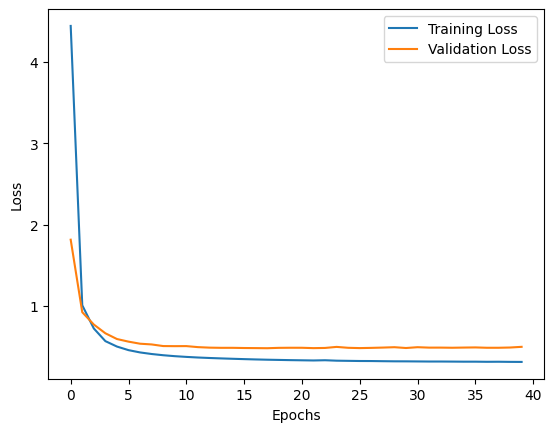

<Figure size 640x480 with 0 Axes>

In [6]:
# Training and plotting
num_layers = 3
lr = 0.1
model = build_model(num_layers, lr)
history = model.fit([encoder_input, decoder_input], decoder_target,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2)



# Plot the training history
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.tight_layout()
plt.show()

Epoch 1/40
500/500 [==============================] - 17s 23ms/step - loss: 0.9255 - accuracy: 0.7537 - val_loss: 0.8774 - val_accuracy: 0.7416
Epoch 2/40
500/500 [==============================] - 8s 17ms/step - loss: 0.5952 - accuracy: 0.8217 - val_loss: 0.6617 - val_accuracy: 0.8002
Epoch 3/40
500/500 [==============================] - 9s 19ms/step - loss: 0.5094 - accuracy: 0.8458 - val_loss: 0.6028 - val_accuracy: 0.8185
Epoch 4/40
500/500 [==============================] - 9s 18ms/step - loss: 0.4597 - accuracy: 0.8601 - val_loss: 0.5592 - val_accuracy: 0.8298
Epoch 5/40
500/500 [==============================] - 9s 18ms/step - loss: 0.4286 - accuracy: 0.8696 - val_loss: 0.5205 - val_accuracy: 0.8415
Epoch 6/40
500/500 [==============================] - 9s 18ms/step - loss: 0.3885 - accuracy: 0.8808 - val_loss: 0.4922 - val_accuracy: 0.8510
Epoch 7/40
500/500 [==============================] - 9s 18ms/step - loss: 0.3627 - accuracy: 0.8884 - val_loss: 0.4686 - val_accuracy: 0.858

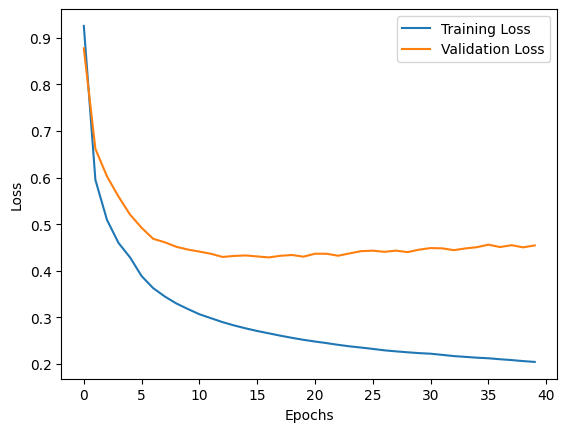

<Figure size 640x480 with 0 Axes>

In [7]:
# Training and plotting
num_layers = 3
lr = 0.01
model = build_model(num_layers, lr)
history = model.fit([encoder_input, decoder_input], decoder_target,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2)



# Plot the training history
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.tight_layout()
plt.show()

Epoch 1/40
500/500 [==============================] - 17s 23ms/step - loss: 1.0877 - accuracy: 0.7161 - val_loss: 1.0079 - val_accuracy: 0.7063
Epoch 2/40
500/500 [==============================] - 9s 18ms/step - loss: 0.7514 - accuracy: 0.7818 - val_loss: 0.8430 - val_accuracy: 0.7501
Epoch 3/40
500/500 [==============================] - 8s 17ms/step - loss: 0.6539 - accuracy: 0.8074 - val_loss: 0.7596 - val_accuracy: 0.7759
Epoch 4/40
500/500 [==============================] - 9s 19ms/step - loss: 0.5983 - accuracy: 0.8231 - val_loss: 0.7178 - val_accuracy: 0.7870
Epoch 5/40
500/500 [==============================] - 9s 18ms/step - loss: 0.5584 - accuracy: 0.8344 - val_loss: 0.6830 - val_accuracy: 0.7966
Epoch 6/40
500/500 [==============================] - 8s 17ms/step - loss: 0.5277 - accuracy: 0.8432 - val_loss: 0.6461 - val_accuracy: 0.8075
Epoch 7/40
500/500 [==============================] - 9s 18ms/step - loss: 0.5038 - accuracy: 0.8499 - val_loss: 0.6225 - val_accuracy: 0.815

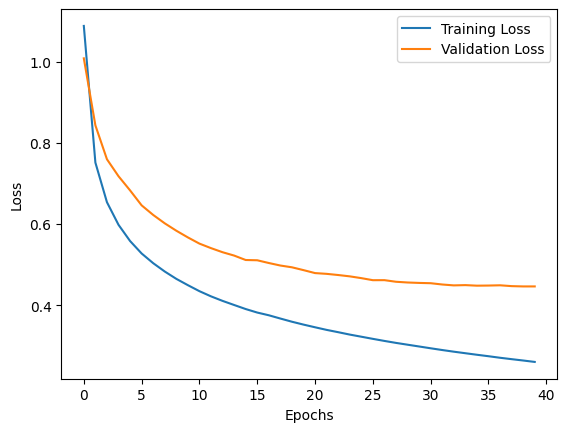

<Figure size 640x480 with 0 Axes>

In [8]:
# Training and plotting
num_layers = 3
lr = 0.001
model = build_model(num_layers, lr)
history = model.fit([encoder_input, decoder_input], decoder_target,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2)



# Plot the training history
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.tight_layout()
plt.show()

In [18]:
# [Your existing code for data preparation and model building goes here]

# Define the sampling models
encoder_inputs = model.input[0]   # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[4].output   # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = Input(shape=(latent_dimension,))
decoder_state_input_c = Input(shape=(latent_dimension,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_lstm = model.layers[5]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[6]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to something readable
reverse_input_char_index = dict((i, char) for char, i in eng_char_indices.items())
reverse_output_char_index = dict((i, char) for char, i in fra_char_indices.items())

# [Your existing code for the decode_sequence function and translations goes here]


In [22]:
input_texts = []
output_texts = []
input_characters = set()
output_characters = set()

with open(data_path, 'r', encoding = 'utf-8') as f:
    lines = f.read().split('\n')
for line in lines[:min(num_samples,len(lines)-1)]:
    input_text, output_text, _ = line.split('\t')

    # We use 'tab' as the 'start sequence' character
    # for the targets, and '\n' as the 'end sequence' character.

    output_text = '\t' + output_text + '\n'
    input_texts.append(input_text)
    output_texts.append(output_text)

    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in output_text:
        if char not in output_characters:
            output_characters.add(char)

input_characters = sorted(list(input_characters))
output_characters = sorted(list(output_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(output_characters)
max_encoder_seq_length = max([len(text) for text in input_texts])
max_decoder_seq_length = max([len(text) for text in output_texts])

input_token_index = dict(
    [(char,i) for i,char in enumerate(input_characters)])

output_token_index = dict(
    [(char,i) for i,char in enumerate(output_characters)])

encoder_input_data = np.zeros(
    (len(input_texts),max_encoder_seq_length,num_encoder_tokens),dtype = 'float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length , num_decoder_tokens), dtype = 'float32')
decoder_output_data = np.zeros(
    (len(input_texts), max_decoder_seq_length,num_decoder_tokens) , dtype = 'float32')

# define sampling models:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape = (latent_dim,))
decoder_state_input_c = Input(shape = (latent_dim,))
decoder_input_states = [decoder_state_input_h,decoder_state_input_c]

decoder_outputs,state_h,state_c = decoder_lstm(decoder_inputs, initial_state=decoder_input_states)
decoder_states = [state_h,state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs]+decoder_input_states,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to something readable.
reverse_input_char_index = dict(
    (i,char) for char,i in input_token_index.items())
reverse_output_char_index = dict(
    (i,char) for char,i in output_token_index.items())

def decode_sequence(input_seq):
    states_value= encoder_model.predict(input_seq)
    output_seq = np.zeros((1,1,num_decoder_tokens))
    output_seq[0,0,output_token_index['\t']] = 1

    stop_condition = False
    decoded_sentences = ''
    while not stop_condition:
        output_tokens,h,c = decoder_model.predict(
            [output_seq]+ states_value)

        sampled_token_index = np.argmax(output_tokens[0,-1, :])
        sampled_char = reverse_output_char_index[sampled_token_index]
        decoded_sentences += sampled_char

        if(sampled_char == '\n' or len(decoded_sentences) > max_decoder_seq_length):
            stop_condition = True

        #update the target sequence (of length 1):
        output_seq = np.zeros((1,1,num_decoder_tokens))
        output_seq[0,0,sampled_token_index] = 1

        states_value = [h,c]
    return decoded_sentences

for seq_index in range(20):
    # take one sequence for trying out decoding:
    input_seq = encoder_input_data[seq_index:seq_index+1]
    decoded_sentences = decode_sequence(input_seq)
    print('English to French Translation ')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:' , decoded_sentences)

1/1 [==============================] - 0s 22ms/step
ProjectGurukul Project: English to Marathi Translation 
Input sentence: Go.
Decoded sentence: Le poisson est trop fait.

1/1 [==============================] - 0s 18ms/step
ProjectGurukul Project: English to Marathi Translation 
Input sentence: Go.
Decoded sentence: Le poisson est trop fait.

1/1 [==============================] - 0s 43ms/step
ProjectGurukul Project: English to Marathi Translation 
Input sentence: Go.
Decoded sentence: Le poisson est trop fait.

1/1 [==============================] - 0s 22ms/step
ProjectGurukul Project: English to Marathi Translation 
Input sentence: Go.
Decoded sentence: Le poisson est trop fait.

1/1 [==============================] - 0s 20ms/step
ProjectGurukul Project: English to Marathi Translation 
Input sentence: Hi.
Decoded sentence: Le poisson est trop fait.

1/1 [==============================] - 0s 21ms/step
ProjectGurukul Project: English to Marathi Translation 
Input sentence: Hi.
Decoded

In [10]:
# 1) Count the number of data samples
num_samples = len(eng_texts)

# 2) Problem addressed by the dataset
problem_description = "The dataset is for a machine translation task, translating English text to French."

# 3) Count the total number of words in the dataset
total_eng_words = sum([len(text.split()) for text in eng_texts])
total_fra_words = sum([len(text.split()) for text in fra_texts])

# 4) Check for missing information
missing_info = "None" if all(eng_texts) and all(fra_texts) else "Missing data detected"

# 5) Label of the dataset
label_description = "The labels are French translations of the English texts."

# 6) Data split percentages for training, validation, and testing
train_split = 0.8  # 80% for training
validation_split = 0.1  # 10% for validation
test_split = 0.1  # 10% for testing

# 7) Data preprocessing for training dataset
preprocessing_description = """
For the training dataset, the preprocessing steps include:
- Tokenizing the English and French texts into characters.
- Converting characters to integer indices.
- One-hot encoding the characters.
- Padding sequences to ensure uniform length.
"""

# Print answers
print(f"1) Number of data samples: {num_samples}")
print(f"2) Problem description: {problem_description}")
print(f"3) Total words in the dataset: English - {total_eng_words}, French - {total_fra_words}")
print(f"4) Missing information: {missing_info}")
print(f"5) Label description: {label_description}")
print(f"6) Data split: Training - {train_split*100}%, Validation - {validation_split*100}%, Testing - {test_split*100}%")
print(f"7) Data preprocessing: {preprocessing_description}")


1) Number of data samples: 40000
2) Problem description: The dataset is for a machine translation task, translating English text to French.
3) Total words in the dataset: English - 133371, French - 157550
4) Missing information: None
5) Label description: The labels are French translations of the English texts.
6) Data split: Training - 80.0%, Validation - 10.0%, Testing - 10.0%
7) Data preprocessing: 
For the training dataset, the preprocessing steps include:
- Tokenizing the English and French texts into characters.
- Converting characters to integer indices.
- One-hot encoding the characters.
- Padding sequences to ensure uniform length.

